# Region Growing

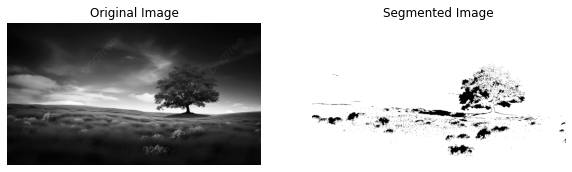

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed, threshold):
    # Initialize the segmentation result
    segmented_image = np.zeros_like(image)
    height, width = image.shape[:2]

    # List of points to be checked
    check_points = [seed]

    # List of directions for 8-connected neighbors
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    while check_points:
        x, y = check_points.pop(0)

        # Avoid re-checking points
        if segmented_image[y, x] != 0:
            continue

        # Mark the current point as part of the region
        segmented_image[y, x] = 255

        # Check the neighbors
        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # Ensure the neighbor is within the image boundaries
            if 0 <= nx < width and 0 <= ny < height:
                # Calculate the intensity difference
                if abs(int(image[ny, nx]) - int(image[y, x])) < threshold:
                    # Add the neighbor to the list of points to be checked
                    check_points.append((nx, ny))

    return segmented_image

# Load the image
image = cv2.imread('im1.jpg', cv2.IMREAD_GRAYSCALE)

# Define the seed point and threshold
seed_point = (100, 100)  # Example seed point
threshold_value = 10  # Example threshold value

# Apply region growing
segmented_result = region_growing(image, seed_point, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()


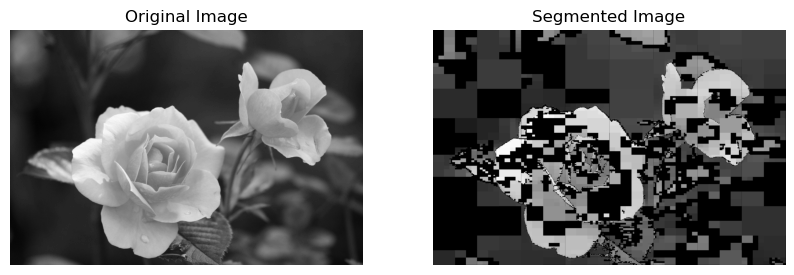

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split_and_merge(image, threshold):
    def split(image, x, y, w, h, threshold):
        # Base case: if the region is smaller than 1x1, return the region
        if w <= 1 or h <= 1:
            return [(x, y, w, h)]
        
        # Calculate the mean and standard deviation of the region
        region = image[y:y+h, x:x+w]
        mean, stddev = cv2.meanStdDev(region)
        
        # If the standard deviation is less than the threshold, return the region
        if stddev[0][0] < threshold:
            return [(x, y, w, h)]
        
        # Otherwise, split the region into four subregions
        half_w, half_h = w // 2, h // 2
        regions = []
        regions.extend(split(image, x, y, half_w, half_h, threshold))
        regions.extend(split(image, x + half_w, y, half_w, half_h, threshold))
        regions.extend(split(image, x, y + half_h, half_w, half_h, threshold))
        regions.extend(split(image, x + half_w, y + half_h, half_w, half_h, threshold))
        
        return regions
    
    def merge(regions, image, threshold):
        def find_neighbors(regions, region):
            neighbors = []
            x, y, w, h = region
            for (nx, ny, nw, nh) in regions:
                if (nx == x + w or nx + nw == x) and ny == y and nh == h:
                    neighbors.append((nx, ny, nw, nh))
                elif (ny == y + h or ny + nh == y) and nx == x and nw == w:
                    neighbors.append((nx, ny, nw, nh))
            return neighbors
        
        merged = np.zeros_like(image, dtype=np.uint8)
        for region in regions:
            x, y, w, h = region
            neighbors = find_neighbors(regions, region)
            region_mean = np.mean(image[y:y+h, x:x+w])
            merge_region = True
            for neighbor in neighbors:
                nx, ny, nw, nh = neighbor
                neighbor_mean = np.mean(image[ny:ny+nh, nx:nx+nw])
                if abs(region_mean - neighbor_mean) > threshold:
                    merge_region = False
                    break
            if merge_region:
                cv2.rectangle(merged, (x, y), (x+w, y+h), int(region_mean), cv2.FILLED)
        return merged

    # Split the image
    height, width = image.shape
    regions = split(image, 0, 0, width, height, threshold)

    # Merge the regions
    merged_image = merge(regions, image, threshold)
    
    return merged_image

# Load the image
image = cv2.imread('flow.jpg', cv2.IMREAD_GRAYSCALE)

# Define the threshold
threshold_value = 10  # Example threshold value

# Apply region splitting and merging
segmented_result = split_and_merge(image, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()


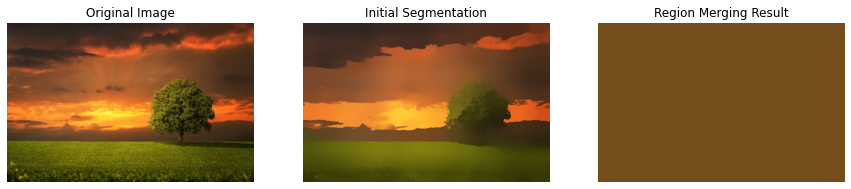

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def initial_segmentation(image, spatial_radius=21, color_radius=51):
    """
    Perform initial segmentation using mean shift filtering.
    """
    return cv2.pyrMeanShiftFiltering(image, sp=spatial_radius, sr=color_radius)

def merge_regions(image, labels, threshold):
    """
    Merge regions based on color similarity.
    """
    height, width = image.shape[:2]
    segmented_image = np.zeros_like(image)
    
    # Create a dictionary to store mean colors of regions
    mean_colors = {}
    
    for y in range(height):
        for x in range(width):
            label = labels[y, x]
            if label not in mean_colors:
                mean_colors[label] = []
            mean_colors[label].append(image[y, x])
    
    for label in mean_colors:
        mean_colors[label] = np.mean(mean_colors[label], axis=0)
    
    def find_neighbors(labels, label):
        neighbors = set()
        for y in range(height):
            for x in range(width):
                if labels[y, x] == label:
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            if 0 <= y+dy < height and 0 <= x+dx < width:
                                neighbor_label = labels[y+dy, x+dx]
                                if neighbor_label != label:
                                    neighbors.add(neighbor_label)
        return neighbors
    
    def merge(label, neighbors):
        region_color = mean_colors[label]
        for neighbor in neighbors:
            neighbor_color = mean_colors[neighbor]
            if np.linalg.norm(region_color - neighbor_color) < threshold:
                labels[labels == neighbor] = label
                mean_colors[label] = (mean_colors[label] + mean_colors[neighbor]) / 2
                del mean_colors[neighbor]
    
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        neighbors = find_neighbors(labels, label)
        merge(label, neighbors)
    
    for y in range(height):
        for x in range(width):
            segmented_image[y, x] = mean_colors[labels[y, x]]
    
    return segmented_image

# Load the image
image = cv2.imread('im2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform initial segmentation
initial_segmented = initial_segmentation(image)

# Convert the initial segmentation result to labels
_, labels = cv2.connectedComponents(cv2.cvtColor(initial_segmented, cv2.COLOR_RGB2GRAY).astype(np.uint8))

# Define the threshold for merging regions
threshold_value = 30  # Example threshold value

# Merge the regions
merged_result = merge_regions(image, labels, threshold_value)

# Display the original, initial segmented, and final merged images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(initial_segmented)
plt.title('Initial Segmentation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(merged_result)
plt.title('Region Merging Result')
plt.axis('off')

plt.show()


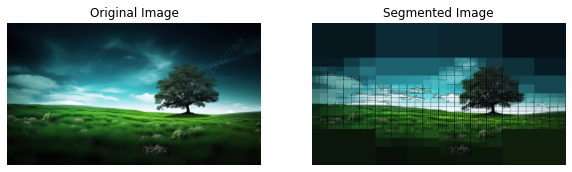

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split(image, x, y, w, h, threshold):
    """
    Recursively split the image into regions based on a homogeneity criterion.
    """
    region = image[y:y+h, x:x+w]
    mean, stddev = cv2.meanStdDev(region)[:2]
    
    # If the region is homogeneous enough, return the region
    if stddev[0] < threshold:
        return [(x, y, w, h)]
    
    # If the region is too small to split, return the region
    if w <= 1 or h <= 1:
        return [(x, y, w, h)]
    
    # Otherwise, split the region into four subregions
    half_w, half_h = w // 2, h // 2
    regions = []
    regions.extend(split(image, x, y, half_w, half_h, threshold))
    regions.extend(split(image, x + half_w, y, half_w, half_h, threshold))
    regions.extend(split(image, x, y + half_h, half_w, half_h, threshold))
    regions.extend(split(image, x + half_w, y + half_h, half_w, half_h, threshold))
    
    return regions

def merge(image, regions, threshold):
    """
    Merge similar adjacent regions.
    """
    labels = np.zeros((image.shape[0], image.shape[1]), np.int32)
    current_label = 1

    for region in regions:
        x, y, w, h = region
        labels[y:y+h, x:x+w] = current_label
        current_label += 1

    merged = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, current_label):
        mask = labels == i
        mean_color = cv2.mean(image, mask.astype(np.uint8))[:3]
        merged[mask] = mean_color

    return merged

def split_and_merge(image, threshold):
    """
    Perform region splitting and merging on the image.
    """
    height, width = image.shape[:2]
    regions = split(image, 0, 0, width, height, threshold)
    merged_image = merge(image, regions, threshold)
    return merged_image

# Load the image
image = cv2.imread('im1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define the threshold for homogeneity
threshold_value = 10  # Example threshold value

# Apply region splitting and merging
segmented_result = split_and_merge(image, threshold_value)

# Display the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result)
plt.title('Segmented Image')
plt.axis('off')

plt.show()


In [33]:
!pip install segmentation

  Using cached segmentation-0.2.2.tar.gz (132 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [22 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\User\AppData\Local\Temp\pip-install-gksy_qob\segmentation_66fa6a2a98a5430faf49c8a07bc02b43\setup.py", line 72, in <module>
      ext_modules=cythonize([
    File "C:\Users\User\anaconda3\lib\site-packages\Cython\Build\Dependencies.py", line 965, in cythonize
      module_list, module_metadata = create_extension_list(
    File "C:\Users\User\anaconda3\lib\site-packages\Cython\Build\Dependencies.py", line 856, in create_extension_list
      m, metadata = create_extension(template, kwds)
    File "C:\Users\User\anaconda3\lib\site-packages\Cython\Build\Dependencies.py", line 738, in default_create_extension
      depends = resolve_depends(kwds['depends'], include_dirs)
    File "C:\Users\User\anaconda3\lib

In [39]:
import cv2
from segmentation import Region_Growing
import pydicom
import os, sys, getopt

DICOM_IMAGE_EXT = '.dcm'
OTHER_IMAGE_EXT = ['.jpg','.png', '.jpeg']
IMAGE_PATH = 'flower.jpg' # Default image path
CONN = 4

def run_region_growing_on_image(image_path):
    """
    1. Load Image in grayscale
    2. Segment the image using region growing and user seeds
    3. Display the result and ask for additional seeds
    4. Repeat Steps 2-3 until user presses Esc

    PS: Press Esc to exit from segmentation
    """
    image_data, image_name = get_image_data(image_path)
    image_data = resize_image(image_data)

    image_data_post_smoothing = apply_gaussian_smoothing(image_data)

    region_growing(image_data_post_smoothing, segmentation_name=image_name+ " segmentation", neighbours=CONN)


def region_growing(image_data, neighbours, threshold=10, segmentation_name="Region Growing"):
    region_growing = Region_Growing(image_data, threshold=threshold, conn=neighbours)
    # Set Seeds
    region_growing.set_seeds()
    # Segmentation
    region_growing.segment()
    # Display Segmentation
    region_growing.display_and_resegment(name=segmentation_name)


def get_image_data(image_path):
    name, ext = os.path.splitext(image_path)
    if ext==DICOM_IMAGE_EXT:
        return (pydicom.read_file(image_path).pixel_array, name)
    elif ext in OTHER_IMAGE_EXT:
        return (cv2.imread(image_path,0), name)
    else:
        print("Invalid Image Format. Supported Image Formats are: {}, {}".format(DICOM_IMAGE_EXT, OTHER_IMAGE_EXT))
        sys.exit()


def resize_image(image_data):
    if image_data.shape[0]>1000:
        image_data = cv2.resize(image_data, (0,0), fx=0.25, fy=0.25)
    if image_data.shape[0]>500:
        image_data = cv2.resize(image_data, (0,0), fx=0.5, fy=0.5)
    return image_data


def apply_gaussian_smoothing(image_data, filter_size=3):
    return cv2.GaussianBlur(image_data,(filter_size,filter_size),0)


def set_cmd_line_arguments():
    global IMAGE_PATH
    global CONN
    n_args = len(sys.argv)
    if n_args==1: 
        print("No image path specified. TERMINATING!!")
    sys.exit()
    argv = sys.argv[1:]
    opts, args = getopt.getopt(argv,"",["image_path=", "conn="])
    for opt, arg in opts:
        if opt == "--image_path":
            IMAGE_PATH = arg
        elif opt == "--conn":
            print(arg)
            CONN= int(arg)
        else:
            print("Make sure to spell 'image_path' correctly")
            sys.exit()
    print("Image Path: {}".format(IMAGE_PATH))


if __name__ == "__main__":
    set_cmd_line_arguments()
    run_region_growing_on_image(IMAGE_PATH)

ModuleNotFoundError: No module named 'segmentation'

In [37]:
import sys
import cv2
import numpy as np

SAVE = 's'
ESC_KEY = 27

class Region_Growing():

    def __init__(self, img, threshold, conn=4):
        self.img = img
        self.segmentation = np.zeros(img.shape)
        self.threshold = threshold
        self.seeds = []
        if conn==4:
            self.orientations = [(1,0),(0,1),(-1,0),(0,-1)]
        elif conn == 8:
            self.orientations = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)] # 8 connectivity
        else:
            raise ValueError("(%s) Connectivity type not known (4 or 8 available)!" % (sys._getframe().f_code.co_name))


    def set_seeds(self, name="Region Growing"):
        """
        Set seed points using left mouse button. 
        """
        self.seeds = []
        self.img = np.array(self.img, dtype=np.uint8)
        cv2.namedWindow(name, cv2.WINDOW_NORMAL)
        cv2.setMouseCallback(name, self.__on_left_click)
        cv2.imshow(name, self.img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


    def segment(self):
        """
        Segment the image with the provided user seeds using region growing
        """
        for seed in self.seeds:
            curr_pixel = [seed[1],seed[0]]
            if self.segmentation[curr_pixel[0], curr_pixel[1]]==255: continue # pixel already explored
            contour = []
            seg_size = 1
            mean_seg_value = (self.img[curr_pixel[0],curr_pixel[1]])
            dist = 0
            while(dist<self.threshold):
            # Include current pixel in segmentation
                self.segmentation[curr_pixel[0], curr_pixel[1]]=255
                # Explore neighbours of current pixel
                contour = self.__explore_neighbours(contour, curr_pixel)
                # Get the nearest neighbour
                nearest_neighbour_idx, dist = self.__get_nearest_neighbour(contour, mean_seg_value)
                # If no more neighbours to grow, move to the next seed
                if nearest_neighbour_idx==-1: break
                # Update Current pixel to the nearest neighbour and increment size
                curr_pixel = contour[nearest_neighbour_idx]
                seg_size+=1
                # Update Mean pixel value for segmentation
                mean_seg_value = (mean_seg_value*seg_size + float(self.img[curr_pixel[0],curr_pixel[1]]))/(seg_size+1)
                # Delete from contour once the nearest neighbour as chosen as the current node for expansion
                del contour[nearest_neighbour_idx]
        return self.segmentation


    def display_and_resegment(self, name="Region Growing"):
        """
        Display the segmented image and ask for user seeds for further segmentation.
        Press "s" to save the segmented image
        Press "Esc" to cancel further segmentation and exit the program
        """
        self.seeds = []
        # Display original image where segmentation was not done
        result = np.maximum(self.img, self.segmentation)
        result = np.array(result, dtype=np.uint8)
        # Display the result 
        cv2.namedWindow(name, cv2.WINDOW_NORMAL)
        # Activate mouse click on the image window
        cv2.setMouseCallback(name, self.__on_left_click)
        cv2.imshow(name, result)
        key = cv2.waitKey(0)
        cv2.destroyAllWindows()
        # Press "s" to save the segmented result
        if chr(key)==SAVE: cv2.imwrite(name+'.png', result)
        # Press "Esc" to if no more seeds are required and end the program
        if key==ESC_KEY: return
            # Resegment the image using new seeds
        self.segment()
        self.display_and_resegment(name=name)


    def __explore_neighbours(self, contour, current_pixel):
        for orientation in self.orientations:
            neighbour = self.__get_neighbouring_pixel(current_pixel, orientation, self.img.shape)
            if neighbour is None:
                continue
            if self.segmentation[neighbour[0],neighbour[1]]==0:
                contour.append(neighbour)
                self.segmentation[neighbour[0],neighbour[1]]=150
        return contour


    def __get_neighbouring_pixel(self, current_pixel, orient, img_shape):
        neighbour = (current_pixel[0]+orient[0], current_pixel[1]+orient[1])
        if self.is_pixel_inside_image(pixel=neighbour, img_shape=img_shape):
            return neighbour
        else:
            return None


    def __get_nearest_neighbour(self, contour, mean_seg_value):
        dist_list = [abs(self.img[pixel[0], pixel[1]] - mean_seg_value) for pixel in contour]
        if len(dist_list)==0: return -1, 1000
        min_dist = min(dist_list)
        index = dist_list.index(min_dist)
        return index, min_dist


    def is_pixel_inside_image(self, pixel, img_shape):
        return 0<=pixel[0]<img_shape[0] and 0<=pixel[1]<img_shape[1]


    def __on_left_click(self, event, x, y, flags, param):
        """
        Function automatically called by opencv2 when having mouse events on a 
        displayed frame. In here, we are searching for a left mouse click
        """
        if event == cv2.EVENT_LBUTTONDOWN:
            self.seeds.append((x, y))